In [2]:
%pylab inline
import matplotlib.pylab as plt
import logging
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/home/sheeba/.local/lib/python2.7/site-packages/scipy/sparse/lil.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/home/sheeba/.local/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:165: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._shortest_path import shortest_path, floyd_warshall, dijkstra,\
/home/sheeba/.local/lib/python2.7/site-packages/scipy/sparse/csgraph/_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._tools import csgraph_to_dense, csgraph_from_dense,\
/home/sheeba/.local/lib/python2.7/site-

In [3]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [4]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=50, resize=0.4)

2019-04-21 23:38:34,157 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012
2019-04-21 23:38:35,228 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2019-04-21 23:38:36,075 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
2019-04-21 23:38:37,070 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015


In [5]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# fot machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)

classh, bins = np.histogram(y, range(n_classes+1))

for k in range(len(target_names)):
    print(target_names[k], classh[k])

Total dataset size:
n_samples: 1560
n_features: 1850
('Ariel Sharon', 77)
('Colin Powell', 236)
('Donald Rumsfeld', 121)
('George W Bush', 530)
('Gerhard Schroeder', 109)
('Hugo Chavez', 71)
('Jacques Chirac', 52)
('Jean Chretien', 55)
('John Ashcroft', 53)
('Junichiro Koizumi', 60)
('Serena Williams', 52)
('Tony Blair', 144)


In [6]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)

In [18]:
###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((n_components, h, w))
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [19]:
print(X_train.shape, X_train_pca.shape)

((1170, 1850), (1170, 150))


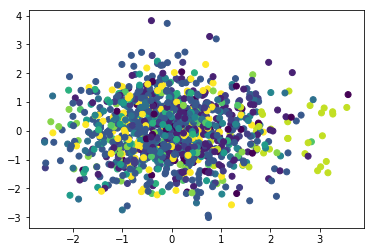

In [20]:
plt.figure()
plt.scatter( X_train_pca[:,0], X_train_pca[:,1], c=y_train )
plt.show()

In [21]:
# Train a SVM classification model
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print(clf.best_estimator_)

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [22]:
# Quantitative evaluation of the model quality on the test set
y_pred = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.77      0.77      0.77        22
     Colin Powell       0.71      0.85      0.78        59
  Donald Rumsfeld       0.77      0.73      0.75        33
    George W Bush       0.82      0.85      0.83       125
Gerhard Schroeder       0.78      0.72      0.75        25
      Hugo Chavez       1.00      0.76      0.86        21
   Jacques Chirac       0.50      0.25      0.33         8
    Jean Chretien       0.85      1.00      0.92        11
    John Ashcroft       0.71      0.67      0.69        18
Junichiro Koizumi       0.86      0.71      0.77        17
  Serena Williams       0.68      0.72      0.70        18
       Tony Blair       0.81      0.76      0.78        33

        micro avg       0.78      0.78      0.78       390
        macro avg       0.77      0.73      0.74       390
     weighted avg       0.79      0.78      0.78       390



In [23]:
C = confusion_matrix(y_test, y_pred, labels=range(n_classes))
print("Confusion matrix:\n", C)
print("Number of test examples for each class:\n", np.sum(C,axis=1))
avg = np.diag(C)/np.sum(C,axis=1).astype('float')
print("Classification accuracy for each class:\n", avg)
print("Average recognition rate:", np.mean(avg))
print( "Overall recognition rate:", np.sum(np.diag(C))/np.sum(C).astype('float'))

('Confusion matrix:\n', array([[ 17,   3,   0,   2,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,  50,   1,   6,   0,   0,   0,   0,   0,   0,   0,   1],
       [  3,   3,  24,   2,   0,   0,   1,   0,   0,   0,   0,   0],
       [  1,   7,   2, 106,   1,   0,   0,   2,   1,   2,   2,   1],
       [  0,   2,   1,   1,  18,   0,   0,   0,   0,   0,   1,   2],
       [  0,   2,   0,   1,   1,  16,   0,   0,   0,   0,   0,   1],
       [  0,   0,   0,   4,   1,   0,   2,   0,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,  11,   0,   0,   0,   0],
       [  0,   1,   1,   2,   1,   0,   0,   0,  12,   0,   0,   1],
       [  0,   0,   0,   1,   1,   0,   0,   0,   3,  12,   0,   0],
       [  0,   2,   1,   2,   0,   0,   0,   0,   0,   0,  13,   0],
       [  0,   0,   1,   3,   0,   0,   1,   0,   1,   0,   2,  25]]))
('Number of test examples for each class:\n', array([ 22,  59,  33, 125,  25,  21,   8,  11,  18,  17,  18,  33]))
('Classification accuracy for e

In [24]:
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


In [25]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

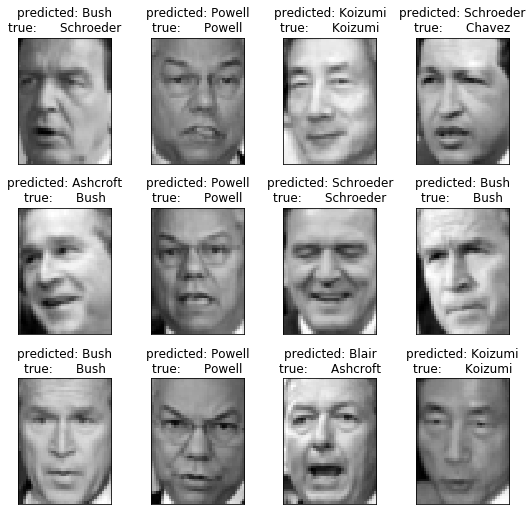

In [26]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)


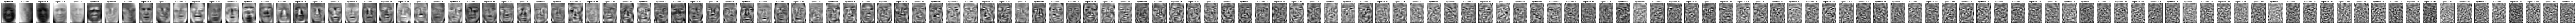

In [27]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w, 1, eigenfaces.shape[0])

plt.show()